In [100]:
import dandelion as ddl
import pandas as pd
import scanpy as sc
import anndata as ad
import muon as mu
import mudata as md
from mudata import MuData
import numpy as np
import warnings
import os

import scirpy as ir
from cycler import cycler

from matplotlib import cm as mpl_cm
from matplotlib import pyplot as plt

from palmotif import compute_motif, svg_logo
import seaborn as sb
warnings.simplefilter(action="ignore", category=pd.errors.DtypeWarning)
warnings.filterwarnings("ignore")
ddl.logging.print_header()

# Desactivar todos los warnings
warnings.filterwarnings("ignore")

# Opcional: Desactivar warnings específicos (ejemplo: FutureWarnings de anndata)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=pd.errors.DtypeWarning)

# Si usas tqdm y deseas evitar sus warnings
from tqdm import TqdmWarning
warnings.simplefilter(action="ignore", category=TqdmWarning)
import pydeseq2 
from pydeseq2.default_inference import DefaultInference
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

dandelion==0.5.0 pandas==2.2.3 numpy==1.26.4 matplotlib==3.9.3 networkx==3.4.2 scipy==1.14.1


In [7]:
mdata_file = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/05_datos_integrados/mudata_harmony_conTCR_KNN_leiden.h5mu"
mdata = mu.read(mdata_file)

In [8]:
# Extraer el objeto AnnData correspondiente a 'gex'
adata_gex = mdata.mod['gex']

In [9]:
adata_gex

AnnData object with n_obs × n_vars = 49043 × 23209
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'prediction', 'doublet', 'doublet_filtered', 'Sample', 'n_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'ATLAS_TIL_KNN', 'ATLAS_TIL_score', 'Celltypist', 'Celltypist_score', 'leiden', 'leiden_names'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors'
    obsm: 'X_pca_harmony', 'X_umap'
    layers: 'counts_soupx_crude', 'original_counts'
    obsp: 'connectivities', 'distances'

In [10]:
with open("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/FIRMAS_SH-TCR/genes_avidity_signature.csv", 'r') as f:
    gene_list = [line.strip() for line in f if line.strip()]

# Reemplaza "TMEM173" por "STING1" y "VARS" por "VARS1"
gene_list = ['STING1' if gene == 'TMEM173' else 'VARS1' if gene == 'VARS' else gene for gene in gene_list]

print(gene_list)

['ABCD1', 'ADAM8', 'AHCY', 'AKT1', 'ANKRD52', 'AP1S1', 'ARID5A', 'ATAD1', 'ATIC', 'ATP1A1', 'BAG6', 'BTBD19', 'BTBD2', 'C1QA', 'CAPN2', 'CCT8', 'CD6', 'CD7', 'CD74', 'CD81', 'CENPB', 'CHST11', 'CHSY1', 'CLASRP', 'COASY', 'CORO1A', 'CORO1B', 'CRTC2', 'CSK', 'DAPK3', 'DBNL', 'DENND2D', 'EEF2', 'ENO1', 'ENTPD1', 'EPAS1', 'EPN1', 'FCER1G', 'FCHO1', 'FMNL3', 'GANAB', 'HERPUD1', 'HIRA', 'IFI30', 'IL2RB', 'IPO4', 'IPO5', 'JADE2', 'JAK3', 'LAP3', 'MAZ', 'MCM3', 'MCM4', 'MCM5', 'MIDN', 'MTA1', 'MYO1G', 'NAA10', 'NACC1', 'NFKB2', 'NSUN2', 'OGFR', 'PKM', 'POLD2', 'PRKACA', 'PRPF19', 'PSMD3', 'PTBP1', 'PTCH1', 'RPS6KA4', 'SASH3', 'SEMA4A', 'SLC16A3', 'SLC52A2', 'SNX25', 'STAT5A', 'STMN1', 'TAP1', 'TAP2', 'TCIRG1', 'TET3', 'TFDP1', 'TICAM1', 'TMC8', 'STING1', 'TRABD', 'TRAP1', 'TRIM25', 'TRIM28', 'TWF2', 'TXNDC5', 'UPF1', 'VARS1', 'VASP', 'WDR1', 'ZBTB32', 'ZDHHC8']


In [11]:
sc.tl.score_genes(
    adata_gex, 
    gene_list=gene_list,     # la lista de genes que leíste
    score_name='avidity_score', 
    use_raw=False
)

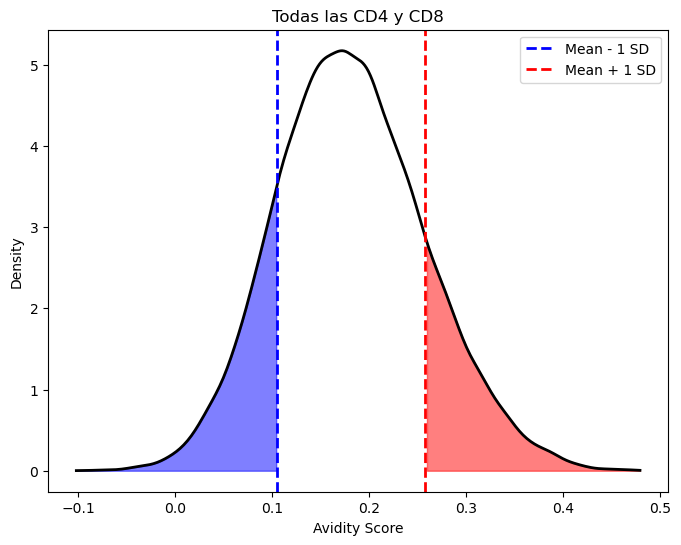

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Obtener el vector de 'avidity_score' (asegúrate de que es numérico)
scores = adata_gex.obs['avidity_score'].values

# Calcular media y desviación estándar
mean_score = np.mean(scores)
std_score = np.std(scores)

# Estimar la densidad usando gaussian_kde
density = gaussian_kde(scores)
xs = np.linspace(scores.min(), scores.max(), 300)
ys = density(xs)

# Crear la figura
plt.figure(figsize=(8,6))

# Graficar la curva de densidad
plt.plot(xs, ys, color='black', linewidth=2)

# Sombrear el área de baja avidez (por debajo de mean - std) en azul
plt.fill_between(xs, ys, where=xs <= (mean_score - std_score), color='blue', alpha=0.5)

# Sombrear el área de alta avidez (por encima de mean + std) en rojo
plt.fill_between(xs, ys, where=xs >= (mean_score + std_score), color='red', alpha=0.5)

# Dibujar líneas verticales en mean - std y mean + std
plt.axvline(mean_score - std_score, color='blue', linestyle='--', linewidth=2, label='Mean - 1 SD')
plt.axvline(mean_score + std_score, color='red', linestyle='--', linewidth=2, label='Mean + 1 SD')

plt.xlabel('Avidity Score')
plt.ylabel('Density')
plt.title('Todas las CD4 y CD8')
plt.legend()
plt.show()


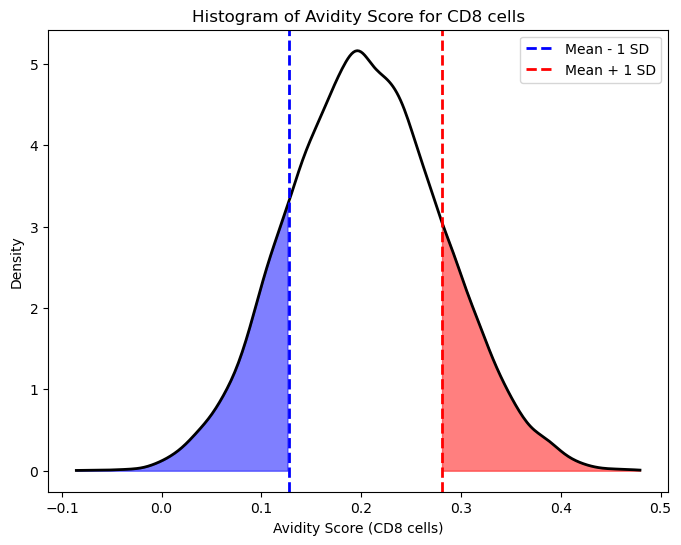

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Filtrar las células cuyo valor en 'ATLAS_TIL_KNN' contenga "CD8"
cd8_mask = adata_gex.obs['ATLAS_TIL_KNN'].str.contains("CD8")
scores_cd8 = adata_gex.obs.loc[cd8_mask, 'avidity_score']

# Calcular la media y la desviación estándar para las células CD8
mean_cd8 = scores_cd8.mean()
std_cd8 = scores_cd8.std()

# Estimar la densidad de 'avidity_score' con gaussian_kde
density_cd8 = gaussian_kde(scores_cd8)
xs = np.linspace(scores_cd8.min(), scores_cd8.max(), 300)
ys = density_cd8(xs)

# Crear la gráfica
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, color='black', linewidth=2)

# Sombrea el área por debajo de (mean - std) en azul
plt.fill_between(xs, ys, where=xs <= (mean_cd8 - std_cd8), color='blue', alpha=0.5)

# Sombrea el área por encima de (mean + std) en rojo
plt.fill_between(xs, ys, where=xs >= (mean_cd8 + std_cd8), color='red', alpha=0.5)

# Dibujar líneas verticales en mean - std y mean + std
plt.axvline(mean_cd8 - std_cd8, color='blue', linestyle='--', linewidth=2, label='Mean - 1 SD')
plt.axvline(mean_cd8 + std_cd8, color='red', linestyle='--', linewidth=2, label='Mean + 1 SD')

plt.xlabel('Avidity Score (CD8 cells)')
plt.ylabel('Density')
plt.title('Histogram of Avidity Score for CD8 cells')
plt.legend()
plt.show()


#### Añadimos la etiqueta de high low or medium

In [12]:
# Creamos la máscara de células CD8
cd8_mask = adata_gex.obs['ATLAS_TIL_KNN'].str.contains("CD8")

# Extraemos el score de las células CD8
scores_cd8 = adata_gex.obs.loc[cd8_mask, 'avidity_score']

# Calculamos la media y la desviación estándar de las células CD8
mean_cd8 = scores_cd8.mean()
std_cd8 = scores_cd8.std()

# Definimos la función para clasificar
def classify_avidity(score, mean_val, std_val):
    if score <= (mean_val - std_val):
        return "low"
    elif score >= (mean_val + std_val):
        return "high"
    else:
        return "mid"  # por si quieres etiquetar las intermedias, de lo contrario, podrías dejarlas en None

# Creamos una nueva columna 'Avidity' en adata_gex.obs, sólo para las CD8
# Las no-CD8 se quedan con np.nan o "not_cd8", según prefieras
avidity_labels = []
for idx, row in adata_gex.obs.iterrows():
    if cd8_mask[idx]:
        score = row['avidity_score']
        avidity_labels.append(classify_avidity(score, mean_cd8, std_cd8))
    else:
        avidity_labels.append(np.nan)  # o "not_cd8"

adata_gex.obs['Avidity'] = avidity_labels

In [14]:
import scipy.sparse as sp

# Asumiendo que adata_gex.layers['counts_soupx_crude'] es del mismo shape que adata_gex.X
# y que no vas a necesitar la versión normalizada en .X
adata_gex.X = adata_gex.layers['counts_soupx_crude']

# Si está en formato denso y prefieres sparse, podrías hacer algo como:
# adata_gex.X = sp.csr_matrix(adata_gex.layers['counts_soupx_crude'])

In [15]:
# 1. Filtrar células CD8 y quedarse solo con aquellas etiquetadas "low" o "high" en 'Avidity'
mask_low_high = adata_gex.obs['Avidity'].isin(["low", "high"])
adata_lh = adata_gex[mask_low_high, :].copy()

In [16]:
adata_lh

AnnData object with n_obs × n_vars = 6842 × 23209
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'prediction', 'doublet', 'doublet_filtered', 'Sample', 'n_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'ATLAS_TIL_KNN', 'ATLAS_TIL_score', 'Celltypist', 'Celltypist_score', 'leiden', 'leiden_names', 'avidity_score', 'Avidity'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors'
    obsm: 'X_pca_harmony', 'X_umap'
    layers: 'counts_soupx_crude', 'original_counts'
    obsp: 'connectivities', 'distances'

In [21]:
print(type(raw_matrix))
print(raw_matrix.shape)

<class 'scipy.sparse._csr.csr_matrix'>
(6842, 23209)


In [22]:
raw_array = raw_matrix.toarray() if hasattr(raw_matrix, "toarray") else raw_matrix
print("Shape of raw_array:", raw_array.shape)

Shape of raw_array: (6842, 23209)


In [23]:
# 2. Extraer la matriz de cuentas crudas.
# Se asume que adata_gex.X ya es la capa counts_soupx_crude.
# Convertir a DataFrame: filas = células, columnas = genes.
df_counts = pd.DataFrame(raw_array, index=adata_lh.obs_names, columns=adata_lh.var_names)

In [31]:
# Filtrar genes con al menos 10 lecturas en total
genes_to_keep = df_counts.columns[df_counts.sum(axis=0) >= 10]
df_counts_filtered = df_counts[genes_to_keep]

In [55]:
# 2. Crear un DataFrame con la información de condición y de Sample
df_meta = pd.DataFrame({
    'condition': adata_lh.obs['Avidity'].values,
    'Sample': adata_lh.obs['Sample'].values
}, index=adata_lh.obs_names)

In [73]:
cell_counts = df_meta.groupby(['Sample', 'condition']).size()
print(cell_counts)

Sample     condition
PT_14      high           85
           low          1022
PT_17      high         1042
           low            90
PT_20      high          231
           low           198
PT_22      high          149
           low           632
PT_28      high         1729
           low           211
PT_18      high            0
           low            57
PT_14_pan  high           52
           low            98
PT_41      high           15
           low           285
PT_49      high           52
           low           293
PT_50      high           65
           low           536
dtype: int64


In [84]:
# Creamos una nueva columna 'sample_condition' que combine ambas, separadas por "_"
df_meta['sample_condition'] = df_meta['Sample'].astype(str) + "_" + df_meta['condition'].astype(str)

# Verifica que la nueva columna tenga el formato esperado, por ejemplo:
print(df_meta['sample_condition'].unique())

['PT_14_low' 'PT_14_high' 'PT_17_high' 'PT_17_low' 'PT_20_high'
 'PT_20_low' 'PT_22_high' 'PT_22_low' 'PT_28_high' 'PT_28_low' 'PT_18_low'
 'PT_14_pan_low' 'PT_14_pan_high' 'PT_41_low' 'PT_41_high' 'PT_49_low'
 'PT_49_high' 'PT_50_low' 'PT_50_high']


In [87]:
# Primero, filtra df_meta para eliminar todas las filas cuyo valor en 'Sample' contenga "PT_18"
df_meta_filtered = df_meta[~df_meta['Sample'].str.contains("PT_18")].copy()

# Asegúrate de que df_counts_filtered se alinee con el nuevo índice filtrado
df_counts_filtered_filtered = df_counts_filtered.loc[df_meta_filtered.index]

# Ahora, crea la columna combinada en df_meta_filtered
df_meta_filtered['sample_condition'] = df_meta_filtered['Sample'].astype(str) + "_" + df_meta_filtered['condition'].astype(str)

# Agrupa los conteos según 'sample_condition'
df_pseudobulk = df_counts_filtered_filtered.groupby(df_meta_filtered['sample_condition']).sum()

print("Forma de df_pseudobulk:", df_pseudobulk.shape)


Forma de df_pseudobulk: (18, 16318)


In [92]:
df_pseudo_meta = pd.DataFrame({
    'Sample': df_pseudobulk.index.str.rsplit("_", n=1).str[0],
    'condition': df_pseudobulk.index.str.rsplit("_", n=1).str[1]
}, index=df_pseudobulk.index)


In [93]:
df_pseudo_meta

,Sample,condition
sample_condition,,
PT_14_high,PT_14,high
PT_14_low,PT_14,low
PT_14_pan_high,PT_14_pan,high
PT_14_pan_low,PT_14_pan,low
PT_17_high,PT_17,high
PT_17_low,PT_17,low
PT_20_high,PT_20,high
PT_20_low,PT_20,low
PT_22_high,PT_22,high


In [94]:
# Crear el objeto de inferencia, con 8 CPUs:
inference = pydeseq2.default_inference.DefaultInference(n_cpus=8)

In [95]:
dds = pydeseq2.dds.DeseqDataSet(
    counts=df_pseudobulk,        # Ahora usamos el pseudo-bulk (filas: sample_condition)
    metadata=df_pseudo_meta,      # La metadata pseudo-bulk, con columnas 'Sample' y 'condition'
    design="~ condition",        # Diseño del modelo (la variable de interés es 'condition')
    refit_cooks=True,            # Refina la estimación de outliers (Cook's distance)
    inference=inference          # Objeto de inferencia configurado
)

In [96]:
dds.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.05 seconds.

Fitting dispersions...
... done in 2.95 seconds.

Fitting dispersion trend curve...
... done in 0.52 seconds.

Fitting MAP dispersions...
... done in 3.24 seconds.

Fitting LFCs...
... done in 2.77 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 73 outlier genes.

Fitting dispersions...
... done in 0.04 seconds.

Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.04 seconds.



In [ ]:
import os
import pickle as pkl

OUTPUT_PATH = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/06_analisis_diferencia_expresion"
if SAVE:
    with open(os.path.join(OUTPUT_PATH, "DESEQ2_Avidity_low_high.pkl"), "wb") as f:
        pkl.dump(dds, f)

In [97]:
print(dds)

AnnData object with n_obs × n_vars = 18 × 16318
    obs: 'Sample', 'condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'replace_cooks'


In [131]:
ds = DeseqStats(dds, contrast=["condition", "high", "low"], inference=inference)

In [132]:
ds.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition high vs low
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        88.277549        0.041090  0.156045  0.263320  0.792304  0.947978
A1BG-AS1    13.423954       -0.073093  0.255958 -0.285567  0.775209  0.944599
A2M          3.676321       -0.948468  0.754391 -1.257263  0.208658  0.623452
A2M-AS1      1.026456       -0.122326  0.836885 -0.146168  0.883789       NaN
A2ML1-AS1    1.697544       -1.029464  0.815797 -1.261912  0.206980       NaN
...               ...             ...       ...       ...       ...       ...
ZXDC        40.661684       -0.178158  0.179621 -0.991851  0.321270  0.722459
ZYG11B       7.552367       -0.292228  0.346578 -0.843183  0.399126  0.777563
ZYX        319.164812        0.461636  0.117302  3.935440  0.000083  0.008657
ZZEF1       31.137853       -0.170741  0.210935 -0.809450  0.418257  0.792197
ZZZ3        35.140861       -0.204751  0.180960 -1.131474  0.257855  0.675496

[16

... done in 0.94 seconds.



In [133]:
# 3. Extraer el DataFrame de resultados
res_df = ds.results_df  # contiene columnas como baseMean, log2FoldChange, pvalue, padj, etc.

# 4. Guardar en Excel
res_df.to_excel("DEG_results_high_vs_low.xlsx")

Running Wald tests...
... done in 1.79 seconds.



Log2 fold change & Wald test p-value: condition high vs low
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        88.277549        0.041090  0.156045  0.000000  1.000000  1.000000
A1BG-AS1    13.423954       -0.073093  0.255958  0.000000  1.000000  1.000000
A2M          3.676321       -0.948468  0.754391 -1.124706  0.260714  1.000000
A2M-AS1      1.026456       -0.122326  0.836885 -0.026677  0.978717       NaN
A2ML1-AS1    1.697544       -1.029464  0.815797 -1.139332  0.254565  1.000000
...               ...             ...       ...       ...       ...       ...
ZXDC        40.661684       -0.178158  0.179621 -0.435124  0.663472  1.000000
ZYG11B       7.552367       -0.292228  0.346578 -0.554647  0.579136  1.000000
ZYX        319.164812        0.461636  0.117302  3.082942  0.002050  0.162724
ZZEF1       31.137853       -0.170741  0.210935 -0.335369  0.737347  1.000000
ZZZ3        35.140861       -0.204751  0.180960 -0.578865  0.562680  1.000000

[16

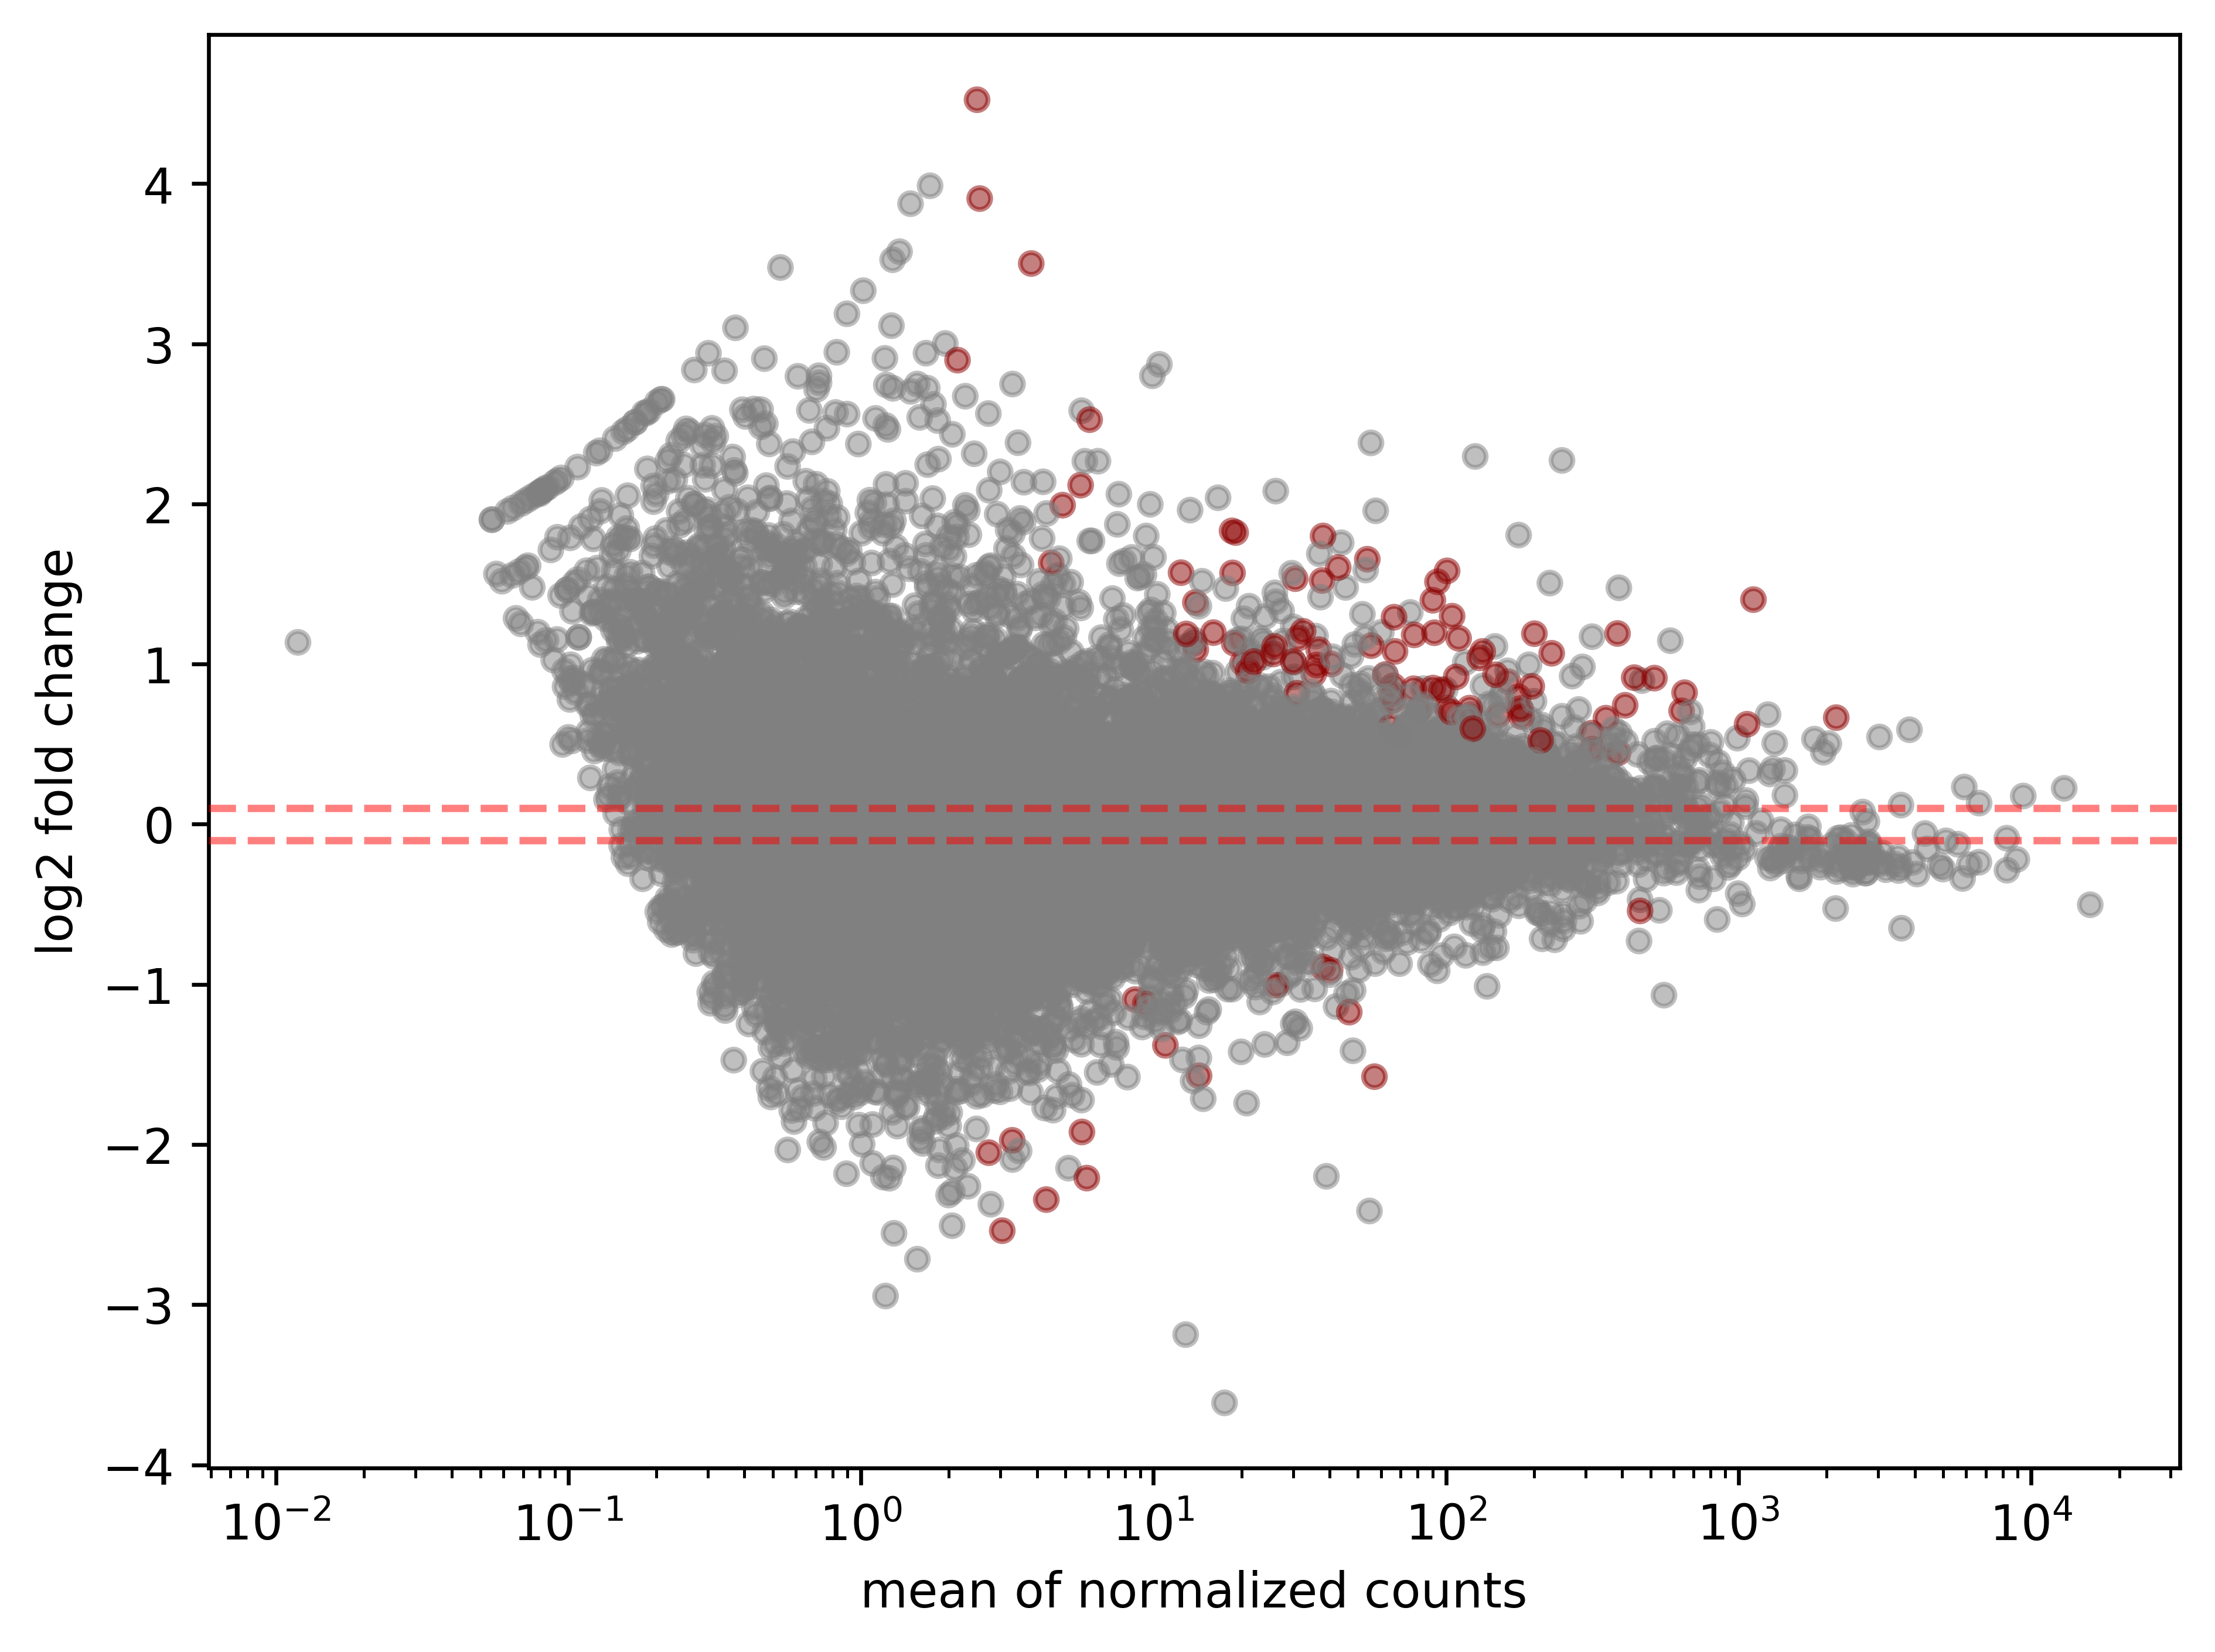

In [124]:
ds.summary(lfc_null=0.1, alt_hypothesis="greaterAbs")
ds.plot_MA(s=20)

In [125]:
# 2. Acceder al DataFrame de resultados (generalmente almacenado en ds.results_df)
res_df = ds.results_df

# 3. Guardar esos resultados en un archivo CSV o Excel para análisis posterior
res_df.to_csv("DEG_results_lfc01_greaterAbs.csv")

In [126]:
ds.lfc_shrink(coeff="condition[T.low]")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition[T.low]
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        88.277549       -0.016871  0.123298  0.000000  1.000000  1.000000
A1BG-AS1    13.423954        0.015573  0.158164  0.000000  1.000000  1.000000
A2M          3.676321        0.027675  0.220188 -1.124706  0.260714  1.000000
A2M-AS1      1.026456        0.006408  0.205588 -0.026677  0.978717       NaN
A2ML1-AS1    1.697544        0.026419  0.237802 -1.139332  0.254565  1.000000
...               ...             ...       ...       ...       ...       ...
ZXDC        40.661684        0.065820  0.146257 -0.435124  0.663472  1.000000
ZYG11B       7.552367        0.038489  0.183385 -0.554647  0.579136  1.000000
ZYX        319.164812       -0.405624  0.119850  3.082942  0.002050  0.162724
ZZEF1       31.137853        0.050027  0.153093 -0.335369  0.737347  1.000000
ZZZ3        35.140861        0.075909  0.150984 -0.578865  0.562680  1.000000

[

... done in 3.76 seconds.



In [127]:
res_shrunk = ds.results_df

In [128]:
res_shrunk.to_csv("DEG_results_shrunk_lfc01_greaterAbs.csv")

In [113]:
from adjustText import adjust_text

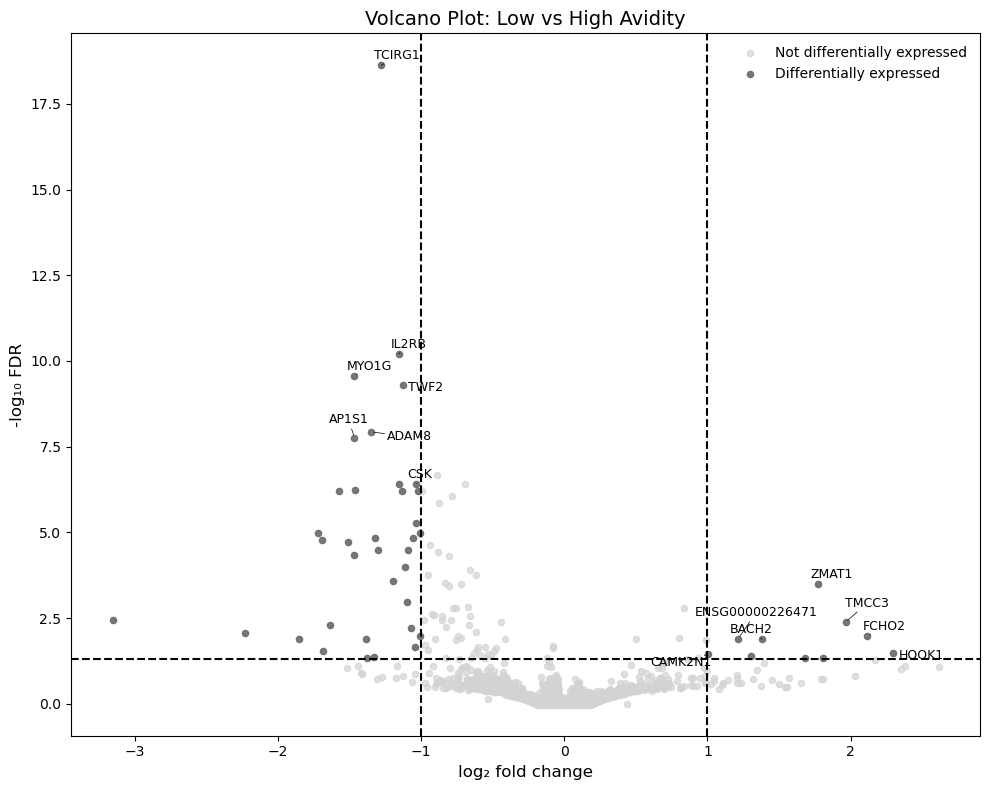

In [115]:
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

plt.figure(figsize=(10, 8))

# Puntos no significativos (gris claro)
mask_non_sig = ~sig_mask
plt.scatter(
    x[mask_non_sig],
    y[mask_non_sig],
    color='lightgray',
    alpha=0.7,
    s=20,
    label='Not differentially expressed'
)

# Puntos significativos (gris oscuro)
plt.scatter(
    x[sig_mask],
    y[sig_mask],
    color='dimgray',
    alpha=0.9,
    s=20,
    label='Differentially expressed'
)

# Líneas de umbral (mismo color y estilo)
plt.axvline(-lfc_thresh, color='black', linestyle='--', linewidth=1.5)
plt.axvline(lfc_thresh, color='black', linestyle='--', linewidth=1.5)
plt.axhline(-np.log10(padj_thresh), color='black', linestyle='--', linewidth=1.5)

plt.xlabel('log₂ fold change', fontsize=12)
plt.ylabel('-log₁₀ FDR', fontsize=12)
plt.title('Volcano Plot: Low vs High Avidity', fontsize=14)

plt.legend(loc='upper right', frameon=False)

# Anotar 10 genes más significativos (por ejemplo, 7 de cada lado)
res_sig = res_df[sig_mask]

# Top 7 con LFC positivo
top_high = res_sig[res_sig['log2FoldChange'] > 0].nsmallest(7, 'padj')
# Top 7 con LFC negativo
top_low = res_sig[res_sig['log2FoldChange'] < 0].nsmallest(7, 'padj')

texts = []

# Anotamos top_high en negro
for gene, row in top_high.iterrows():
    txt = plt.text(
        row['log2FoldChange'],
        -np.log10(row['padj']),
        gene,
        fontsize=9,
        color='black',
        ha='center'
    )
    texts.append(txt)

# Anotamos top_low en negro
for gene, row in top_low.iterrows():
    txt = plt.text(
        row['log2FoldChange'],
        -np.log10(row['padj']),
        gene,
        fontsize=9,
        color='black',
        ha='center'
    )
    texts.append(txt)

# Ajustar las posiciones para evitar solapamientos
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

plt.tight_layout()
plt.show()

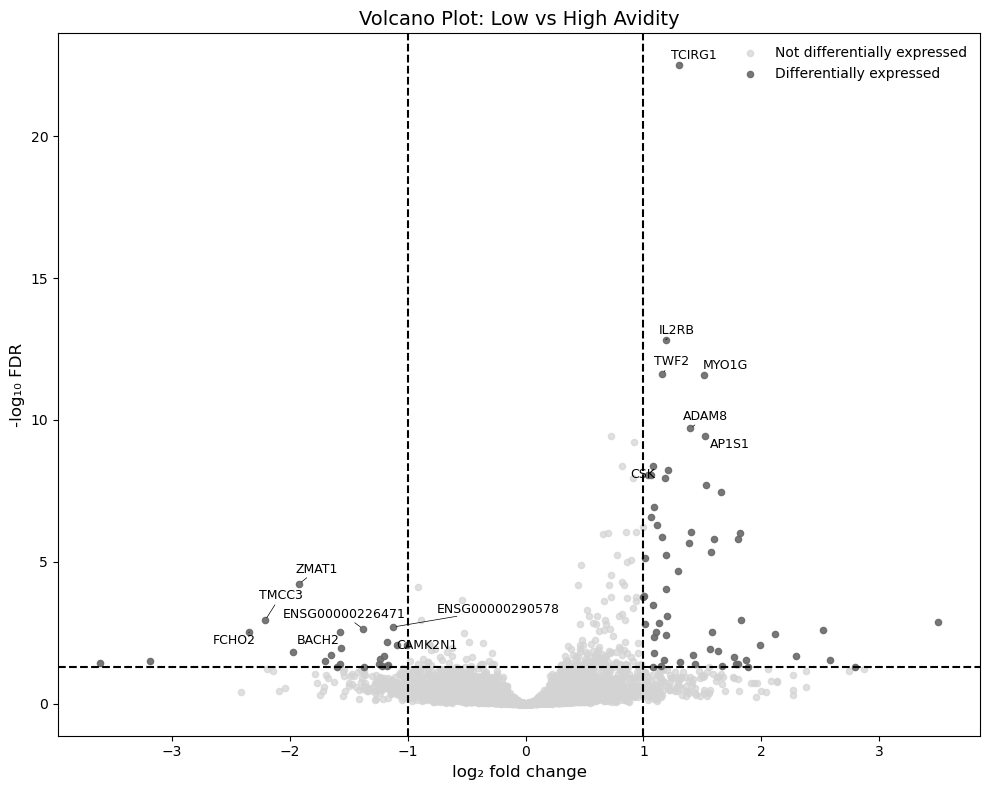

In [134]:
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

# Suponiendo que res_df es tu DataFrame de resultados con columnas:
# 'log2FoldChange' (x),
# 'padj' (para el eje Y como -log10(padj)),
# y alguna máscara sig_mask para indicar genes significativos.

# Configura tus umbrales:
lfc_thresh = 1.0       # |log2FoldChange| > 1
padj_thresh = 0.05     # FDR < 0.05

# Calcula x e y
x = res_df['log2FoldChange']
y = -np.log10(res_df['padj'])

# Define la máscara de genes significativos (por ejemplo, padj<0.05 y |log2FC|>1)
sig_mask = (res_df['padj'] < padj_thresh) & (abs(res_df['log2FoldChange']) > lfc_thresh)

plt.figure(figsize=(10, 8))

# 1. Puntos NO significativos (gris claro)
mask_non_sig = ~sig_mask
plt.scatter(
    x[mask_non_sig],
    y[mask_non_sig],
    color='lightgray',
    alpha=0.7,
    s=20,
    label='Not differentially expressed'
)

# 2. Puntos SIGNIFICATIVOS (gris oscuro)
plt.scatter(
    x[sig_mask],
    y[sig_mask],
    color='dimgray',
    alpha=0.9,
    s=20,
    label='Differentially expressed'
)

# 3. Líneas de umbral (mismo color y estilo)
plt.axvline(-lfc_thresh, color='black', linestyle='--', linewidth=1.5)
plt.axvline(lfc_thresh, color='black', linestyle='--', linewidth=1.5)
plt.axhline(-np.log10(padj_thresh), color='black', linestyle='--', linewidth=1.5)

plt.xlabel('log₂ fold change', fontsize=12)
plt.ylabel('-log₁₀ FDR', fontsize=12)
plt.title('Volcano Plot: Low vs High Avidity', fontsize=14)

plt.legend(loc='upper right', frameon=False)

# 4. Anotar genes más significativos
res_sig = res_df[sig_mask]

# Top 7 con LFC positivo
top_high = res_sig[res_sig['log2FoldChange'] > 0].nsmallest(7, 'padj')
# Top 7 con LFC negativo
top_low = res_sig[res_sig['log2FoldChange'] < 0].nsmallest(7, 'padj')

texts = []

# Anotamos top_high en negro
for gene, row in top_high.iterrows():
    txt = plt.text(
        row['log2FoldChange'],
        -np.log10(row['padj']),
        gene,
        fontsize=9,
        color='black',
        ha='center'
    )
    texts.append(txt)

# Anotamos top_low en negro
for gene, row in top_low.iterrows():
    txt = plt.text(
        row['log2FoldChange'],
        -np.log10(row['padj']),
        gene,
        fontsize=9,
        color='black',
        ha='center'
    )
    texts.append(txt)

# Ajustar las posiciones de las etiquetas para evitar solapamientos
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='-', color='black', lw=0.5)
)

plt.tight_layout()
plt.show()


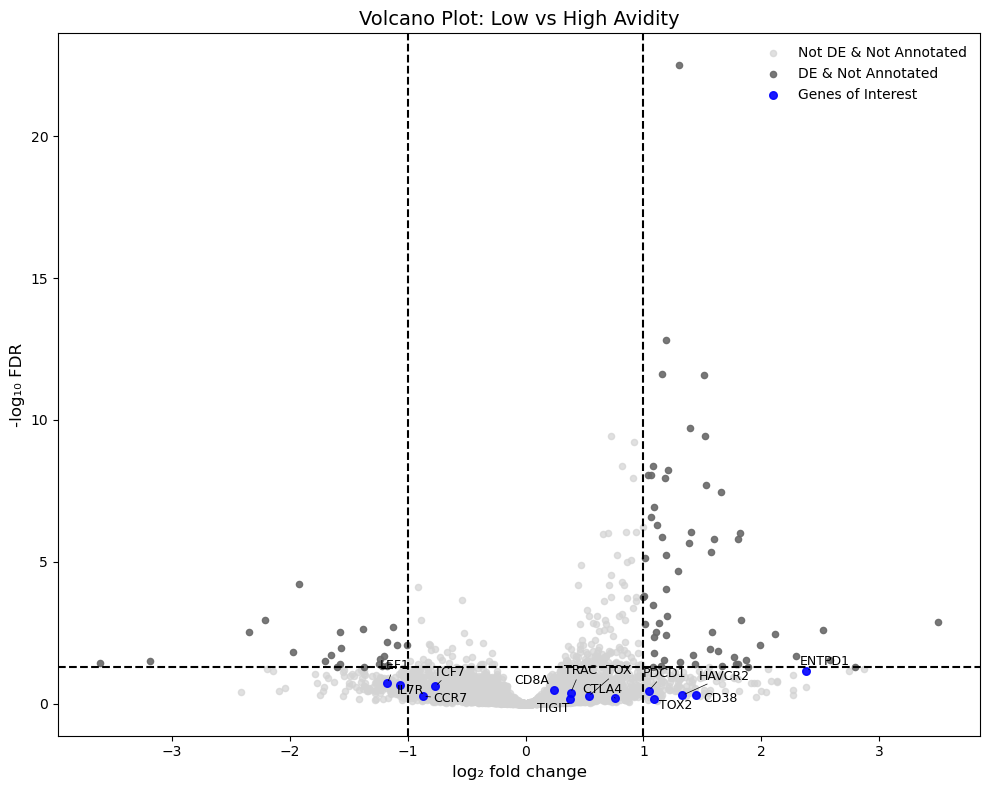

In [138]:
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

# Lista de genes a resaltar en azul
genes_to_annotate = [
    "TCF7", "CCR7", "LEF1", "IL7R",
    "HAVCR2", "ENTPD1", "CD38", "CD8A",
    "PDCD1", "CTLA4", "TOX", "TOX2",
    "TIGIT", "TRAC"
]

lfc_thresh = 1.0      # |log2FoldChange| > 1
padj_thresh = 0.05    # FDR < 0.05

# x e y para todas las filas de res_df
x = res_df['log2FoldChange']
y = -np.log10(res_df['padj'])

# Máscara de significativos
sig_mask = (res_df['padj'] < padj_thresh) & (abs(res_df['log2FoldChange']) > lfc_thresh)

# Máscara de genes a anotar
mask_annotate = res_df.index.isin(genes_to_annotate)

# 1) Genes no anotados y no significativos
mask_non_sig_no_annot = (~sig_mask) & (~mask_annotate)

# 2) Genes no anotados pero significativos
mask_sig_no_annot = (sig_mask) & (~mask_annotate)

# 3) Genes anotados (sin importar significancia)
mask_annot = mask_annotate  # Podrías combinarlos con sig_mask si quisieras

plt.figure(figsize=(10, 8))

# Scatter para genes no anotados y no significativos (gris claro)
plt.scatter(
    x[mask_non_sig_no_annot],
    y[mask_non_sig_no_annot],
    color='lightgray',
    alpha=0.7,
    s=20,
    label='Not DE & Not Annotated'
)

# Scatter para genes no anotados pero significativos (gris oscuro)
plt.scatter(
    x[mask_sig_no_annot],
    y[mask_sig_no_annot],
    color='dimgray',
    alpha=0.9,
    s=20,
    label='DE & Not Annotated'
)

# Scatter para genes anotados (azul)
plt.scatter(
    x[mask_annot],
    y[mask_annot],
    color='blue',
    alpha=0.9,
    s=30,
    label='Genes of Interest'
)

# Líneas de umbral
plt.axvline(-lfc_thresh, color='black', linestyle='--', linewidth=1.5)
plt.axvline(lfc_thresh, color='black', linestyle='--', linewidth=1.5)
plt.axhline(-np.log10(padj_thresh), color='black', linestyle='--', linewidth=1.5)

plt.xlabel('log₂ fold change', fontsize=12)
plt.ylabel('-log₁₀ FDR', fontsize=12)
plt.title('Volcano Plot: Low vs High Avidity', fontsize=14)

plt.legend(loc='upper right', frameon=False)

# Anotar genes de la lista
texts = []
for gene in genes_to_annotate:
    if gene in res_df.index:
        # Extraer coordenadas
        x_coord = res_df.loc[gene, 'log2FoldChange']
        padj_val = res_df.loc[gene, 'padj']
        if padj_val > 0:
            y_coord = -np.log10(padj_val)
        else:
            y_coord = 0  # Evitar -inf si padj=0

        txt = plt.text(
            x_coord,
            y_coord,
            gene,
            fontsize=9,
            color='black',  # Etiqueta en negro
            ha='center'
        )
        texts.append(txt)

# Ajustar texto para evitar solapamientos
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='-', color='black', lw=0.5)
)

plt.tight_layout()
plt.show()



SALE parecido AL ARTÍCULO, LE FALTA MÁS POTENCIA BETA AL ESTUDIO (VEMOS TENDENCIA DE EXPRESIÓN QUE EN EL ARTÍCULO PERO ELLOS USAN MUCHOS MÁS PACIENTES)